In [1]:
import os
import gc
import glob
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        root_list = glob.glob(root_dir)
        self.transform = transform

        self.data = []
        for path in tqdm(root_list):
#             class_name = img_path.split(os.sep)[-2]
            self.data.append(path)
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path = self.data[idx]
        array = np.load(path, allow_pickle = True)
        img = array[0]
        mass = torch.tensor(-(math.log10(array[1])))
       
        if self.transform:
            aug = self.transform(image = img)
            img = aug['image']
        
        img = img.to(torch.float)        

        return img, mass

In [3]:
transforms = A.Compose(
            [
                A.CenterCrop(height = 100, width = 100, p=1.0),
                ToTensorV2()
            ]
        )

In [4]:
BS = 128

In [5]:
data_path = r'../input/gsocml4scimodel1/Model_I/axion/*'
dataset = CustomDataset(data_path, transform = transforms)
len(dataset)

  0%|          | 0/28897 [00:00<?, ?it/s]

28897

In [6]:
m = len(dataset)
test_split_size = 0.1

print("Total training data: " + str(m))

try:
    train_set,val_set=random_split(dataset,[int(m-m*test_split_size),int(m*test_split_size)])
except:
    train_set,val_set=random_split(dataset,[int(m-m*test_split_size),int(m*test_split_size+1)])
    
len(train_set), len(val_set)

Total training data: 28897


(26007, 2890)

In [7]:
test_data_path = r'../input/gsocml4scimodel1test/Model_I_test/axion/*'
test_set = CustomDataset(test_data_path, transform = transforms)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
len(train_set), len(val_set), len(test_set)

(26007, 2890, 5000)

In [9]:
train_loader = DataLoader(train_set, batch_size = BS, shuffle = True)
val_loader = DataLoader(val_set, batch_size = BS, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BS, shuffle = False)

In [10]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([128, 1, 100, 100])

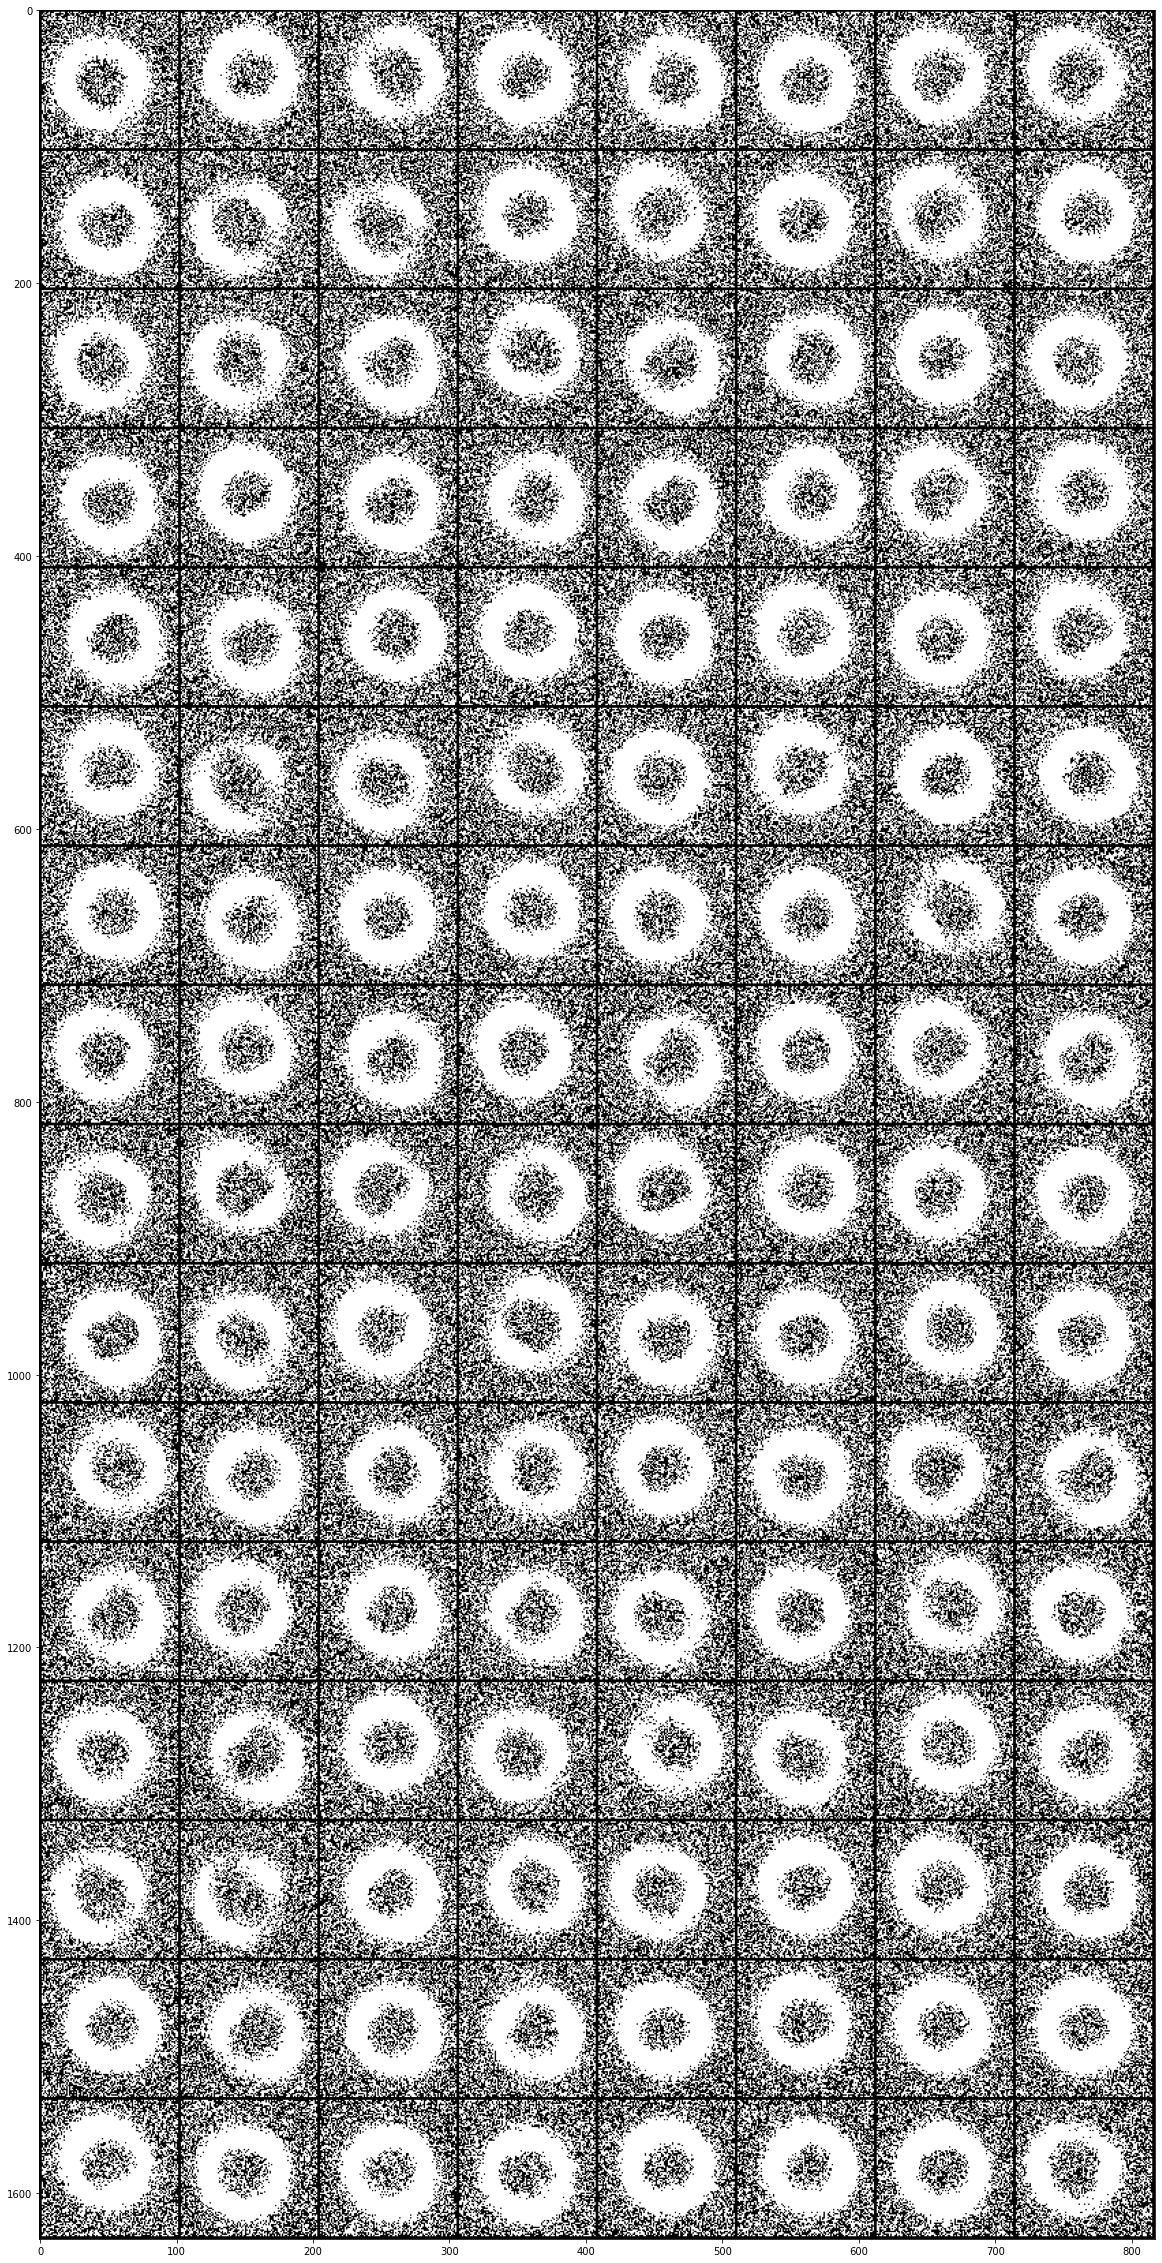

In [11]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [12]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b1',pretrained = pretrained, in_chans = 1)
#         num_in_features = self.model.get_classifier().in_features
        
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1280 * 4 * 4, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.5),
                                
                                nn.Linear(1024, 512),
                                nn.BatchNorm1d(512),
                                nn.PReLU(),
                                nn.Dropout(p = 0.5),
        
                                nn.Linear(512, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),
                                nn.Dropout(p = 0.3),
                                
                                nn.Linear(128, 1)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.view(-1, 1280 * 4 * 4)
        x = self.fc(x)
        return x

In [13]:
model = pre_trained_model()

x = torch.randn(128, 1, 100, 100)
print(model(x).shape)

del model
gc.collect()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


torch.Size([128, 1])


8

In [14]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        
        #forward prop
        y_pred = model(X)
        y_pred = y_pred.view(-1)
        #loss calculation
        loss = criterion(y_pred, y_truth)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return model, np.mean(train_loss)

In [15]:
def val_epoch(model, dataloader,criterion):
    model.eval()
    val_loss = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)

            #forward prop
            y_pred = model(X)
            y_pred = y_pred.view(-1)

            #loss calculation
            loss = criterion(y_pred, y_truth)

            #batch loss
            val_loss.append(loss.detach().cpu().numpy())
            
    return np.mean(val_loss)

In [16]:
def fit_model(model,criterion,optimizer):
    loss_dict = {'train_loss':[],'val_loss':[]}
    
    scheduler = CosineAnnealingWarmRestarts(optimizer,T_0 = 10, T_mult = 1,eta_min = 1e-6, verbose=True)
    
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        model, train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss = val_epoch(model, val_loader, criterion)
        scheduler.step()

        print(f'Train loss:{train_loss}, Val loss:{val_loss}')
        loss_dict['train_loss'].append(train_loss)
        loss_dict['val_loss'].append(val_loss)


    return model, loss_dict

In [17]:
model = pre_trained_model().to(device)

criterion = nn.MSELoss()
EPOCHS = 30
LR = 3e-4

optimizer = optim.Adam(model.parameters(),lr=LR)

In [18]:
#Training model
model, loss_dict = fit_model(model,criterion,optimizer)

Epoch 00000: adjusting learning rate of group 0 to 3.0000e-04.
Epoch 1/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 2.9268e-04.
Train loss:517.6009521484375, Val loss:496.7353820800781
Epoch 2/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00002: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:460.1128234863281, Val loss:404.2809143066406
Epoch 3/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00003: adjusting learning rate of group 0 to 2.3837e-04.
Train loss:342.2810974121094, Val loss:269.362060546875
Epoch 4/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00004: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:215.10562133789062, Val loss:154.43035888671875
Epoch 5/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00005: adjusting learning rate of group 0 to 1.5050e-04.
Train loss:122.8624496459961, Val loss:80.71407318115234
Epoch 6/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00006: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:70.67948150634766, Val loss:46.56396484375
Epoch 7/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00007: adjusting learning rate of group 0 to 6.2626e-05.
Train loss:44.72937774658203, Val loss:28.81362533569336
Epoch 8/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00008: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:32.89956283569336, Val loss:21.0131893157959
Epoch 9/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00009: adjusting learning rate of group 0 to 8.3171e-06.
Train loss:27.923507690429688, Val loss:17.609037399291992
Epoch 10/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00010: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:25.761646270751953, Val loss:16.804079055786133
Epoch 11/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00011: adjusting learning rate of group 0 to 2.9268e-04.
Train loss:16.77069854736328, Val loss:2.6891303062438965
Epoch 12/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00012: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:10.659871101379395, Val loss:1.317068099975586
Epoch 13/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00013: adjusting learning rate of group 0 to 2.3837e-04.
Train loss:10.018816947937012, Val loss:0.7771006226539612
Epoch 14/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00014: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:9.607385635375977, Val loss:0.5195602774620056
Epoch 15/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00015: adjusting learning rate of group 0 to 1.5050e-04.
Train loss:9.04812240600586, Val loss:0.40728846192359924
Epoch 16/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00016: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:9.049174308776855, Val loss:0.6154757142066956
Epoch 17/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00017: adjusting learning rate of group 0 to 6.2626e-05.
Train loss:8.51909065246582, Val loss:0.6978884935379028
Epoch 18/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00018: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:9.16172981262207, Val loss:0.4906812012195587
Epoch 19/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00019: adjusting learning rate of group 0 to 8.3171e-06.
Train loss:8.486688613891602, Val loss:0.5566638708114624
Epoch 20/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00020: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:8.293012619018555, Val loss:0.37707456946372986
Epoch 21/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00021: adjusting learning rate of group 0 to 2.9268e-04.
Train loss:8.594675064086914, Val loss:0.42884477972984314
Epoch 22/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00022: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:8.093759536743164, Val loss:0.40420976281166077
Epoch 23/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00023: adjusting learning rate of group 0 to 2.3837e-04.
Train loss:7.928399562835693, Val loss:4.736363410949707
Epoch 24/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00024: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:7.649282455444336, Val loss:0.3793943226337433
Epoch 25/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00025: adjusting learning rate of group 0 to 1.5050e-04.
Train loss:7.779541015625, Val loss:1.9456785917282104
Epoch 26/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00026: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:7.348394870758057, Val loss:0.35812777280807495
Epoch 27/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00027: adjusting learning rate of group 0 to 6.2626e-05.
Train loss:7.709098815917969, Val loss:0.35273829102516174
Epoch 28/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00028: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:7.085841178894043, Val loss:0.39501816034317017
Epoch 29/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00029: adjusting learning rate of group 0 to 8.3171e-06.
Train loss:7.248950481414795, Val loss:0.71070396900177
Epoch 30/30:


  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 00030: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:7.474174499511719, Val loss:0.3666016459465027


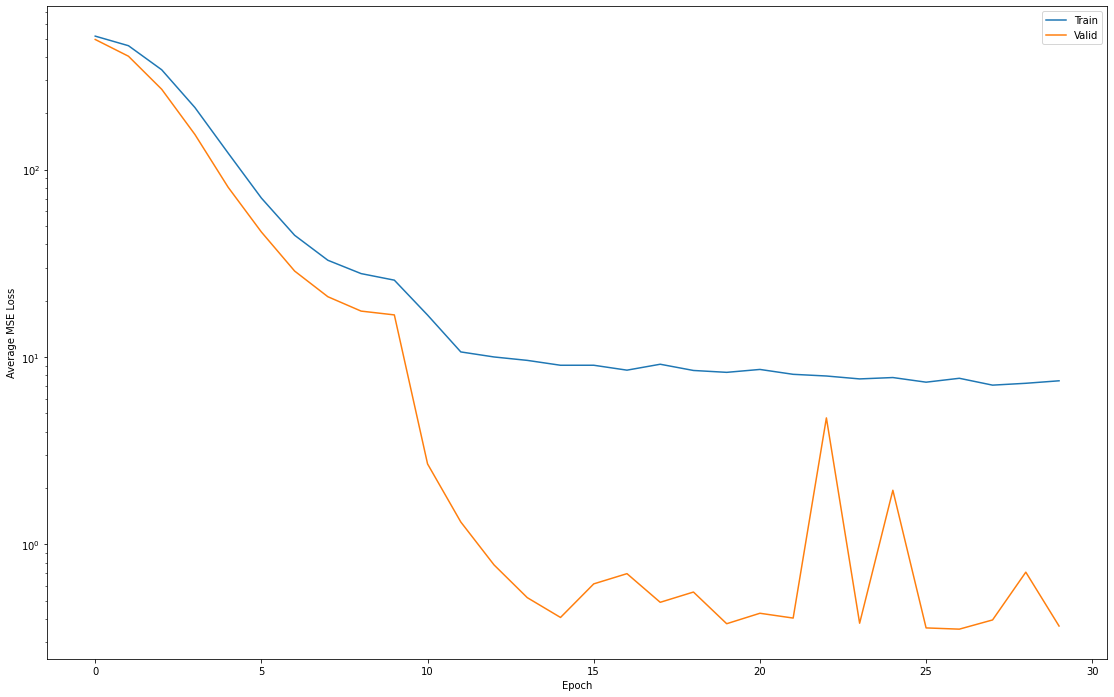

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot losses
plt.figure(figsize=(19,12))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()
plt.savefig("Loss_history.png")

In [20]:
PATH = "effnetB1_reg.pth"
torch.save(model.state_dict(), PATH)

In [21]:
del model
gc.collect()

model = pre_trained_model().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
print(val_epoch(model, train_loader, criterion))
print("Train set MSE:", end = '')

print(val_epoch(model, val_loader, criterion))
print("Val set MSE:", end = '')

print(val_epoch(model, test_loader, criterion))
print("Test set MSE:", end = '')

  0%|          | 0/204 [00:00<?, ?it/s]

0.3661084
Train set MSE:

  0%|          | 0/23 [00:00<?, ?it/s]

0.36660165
Val set MSE:

  0%|          | 0/40 [00:00<?, ?it/s]

0.3689646
Test set MSE: